<h1>Support Vector Machine </h1>

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px


<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.

In [2]:
df = pd.read_csv('./cell_samples.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


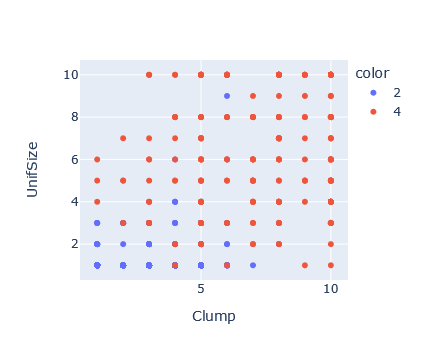

In [5]:
px.scatter(df, x='Clump', y='UnifSize', color=df['Class'].astype('str'))

In [6]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [16]:
#BareNuc contains rows that have ? as entry therfore we 
#can't convert it directly to int using astype()
#We've to use pd.to_numeric function first with errors='coerce'

df['BareNuc'] = pd.to_numeric(df['BareNuc'], errors='coerce').fillna(0)
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes


ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [27]:
feature_df = df.iloc[:,1:10]
X = feature_df.values
X[:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [31]:
target_df = df.iloc[:,-1].astype('int')
y = target_df.values
y[:5]

array([2, 2, 2, 2, 2])

In [33]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=.2,
                                                   random_state=4)

print('Train Set:', x_train.shape, y_train.shape)
print('Test Set:', x_test.shape, y_test.shape)

Train Set: (559, 9) (559,)
Test Set: (140, 9) (140,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [34]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)

SVC()

In [35]:
yhat = clf.predict(x_test)
yhat[:5]

array([4, 2, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score

#plotting confusion matrix
res=confusion_matrix(y_test, yhat,labels=[2,4])
res

array([[87,  1],
       [ 1, 51]], dtype=int64)

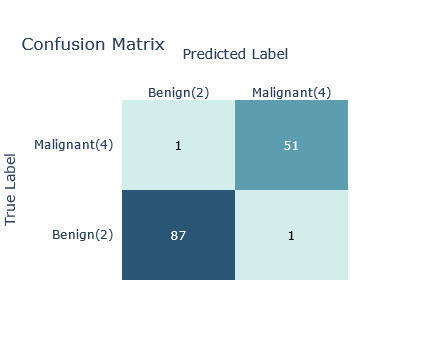

In [41]:
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(res,x=['Benign(2)', 'Malignant(4)'],
                                 y=['Benign(2)', 'Malignant(4)'],
                                 colorscale='teal')

fig.update_layout(xaxis_title='Predicted Label',
                 yaxis_title='True Label',
                 title='Confusion Matrix')
fig.show()


In [42]:
#Classification report

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       0.99      0.99      0.99        88
           4       0.98      0.98      0.98        52

    accuracy                           0.99       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.99      0.99      0.99       140



The accuracy of the model is 99%

In [44]:
jaccard_score(y_test, yhat, pos_label=2)

0.9775280898876404

97% accuracy in finding benign tumors in test set

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?


In [48]:
from sklearn.svm import SVC

clf2 = SVC(kernel='linear')
clf2.fit(x_train, y_train)
Yhat = clf2.predict(x_test)
Yhat[:4]

array([4, 2, 2, 4])

In [50]:
print(classification_report(y_test, Yhat))

              precision    recall  f1-score   support

           2       0.98      0.99      0.98        88
           4       0.98      0.96      0.97        52

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



In [52]:
jaccard_score(y_test, Yhat, pos_label=2)

0.9666666666666667

Accuracy decreased while using linear model
